In [ ]:
import pickle
import pandas as pd
import numpy as np
from scipy import stats
import math
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
%%capture
!pip install -U sentence-transformers
!pip install datasets

In [ ]:
import numpy as np
import pandas as pd
from datasets import load_dataset, ClassLabel, Dataset, dataset_dict, DatasetDict
from transformers import AutoTokenizer, BertTokenizer
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction

In [ ]:
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
sns.set_theme(palette='husl')

In [ ]:
p = pd.read_pickle('/content/drive/MyDrive/Colab_Notebooks/AI4Good_Project/model1data.pkl')
data = pd.DataFrame.from_dict(p)

In [ ]:
#already did stemming, tokenization, removing stopwords etc before putting data into model1data.pkl. 
#the original data is CBET.csv from https://webdocs.cs.ualberta.ca/~zaiane/CBET/CBET.csv and is also cited in our README.md

In [ ]:
#get rid of emojis symbols etc: from https://www.kaggle.com/code/oknashar/emotion-detection-deep-learning

import re
def remove_hashtags(text):
    text = re.sub(r'@\w+', '', text)
    return text
def remove_emojis(text):
    text = [x for x in text.split(' ') if x.isalpha()]
    text = ' '.join(text)
    return text
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def remove_urls(text):
    text = re.sub(r'http\S+', '', text)
    return text
def preprocess(text):
    text = remove_hashtags(text)
    text = remove_emoji(text)
    text = remove_urls(text)
    return text

data['text_clean'] = data['text_clean'].apply(preprocess)

In [ ]:
data['emotions'].value_counts()

love            11536
joy             10766
surprise         9268
sadness          9193
fear             9092
anger            9023
thankfulness     8886
disgust          8631
guilt            8619
Name: emotions, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


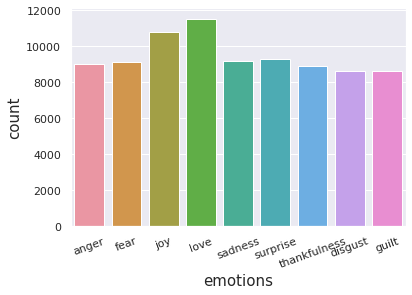

In [ ]:
# plt.figure(figsize=(25,8))
plt.xticks(rotation=20)

plt.xlabel('emotions', fontsize=15)
plt.ylabel('counts', fontsize=15)
sns.countplot(data['emotions'])

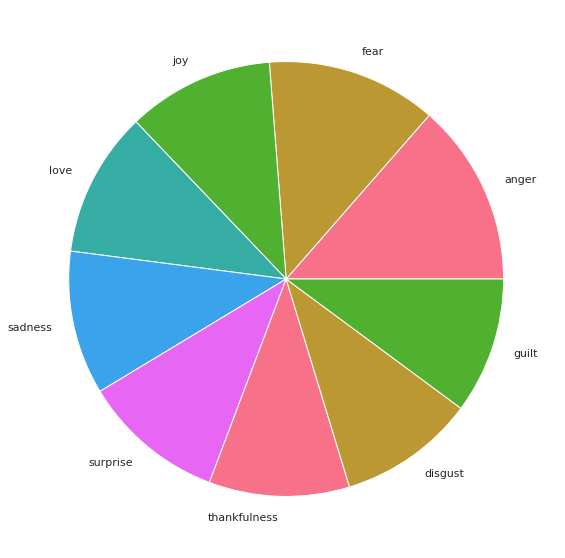

In [ ]:
y = np.array(data['emotions'].value_counts())
mylabels = data['emotions'].unique()

plt.figure(figsize=(10,10))
plt.xticks(rotation=20)
plt.pie(y, labels = mylabels)
plt.show() 
#data is balanced

In [ ]:
#check if null values
data.isna().sum()

text              0
anger             0
fear              0
joy               0
love              0
sadness           0
surprise          0
thankfulness      0
disgust           0
guilt             0
emotions          0
text_clean        0
target_encoded    0
dtype: int64

In [ ]:
words = list()
for i in data['text_clean']:
    for j in i.split(' '):
        words.append(j)

#### **Load data into dataset**

In [ ]:
data = data.drop(columns=['text', 'emotions', 'target_encoded'])
data = data.rename(columns={'text_clean' : 'sentence'})
data = data.set_index('sentence')
data = data.reset_index()

In [ ]:
data.head()

,sentence,anger,fear,joy,love,sadness,surprise,thankfulness,disgust,guilt
0,hour drive appleg four hour north also friday,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,seat avail restaur see coupl take tabl six one...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ptgforza peopl copi hard earn work make differ...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,research onlin wrong everi level judg seem lea...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,photo angri headmast milton grimm miltongrimm ...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# https://huggingface.co/docs/datasets/loading#local-and-remote-files

# #70% train, 30% test+validation
dataset = Dataset.from_pandas(data).train_test_split(test_size=0.2)

In [ ]:
test_valid = dataset['test'].train_test_split(test_size=0.5)

In [ ]:
dataset = DatasetDict({
    'train': dataset['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'anger', 'fear', 'joy', 'love', 'sadness', 'surprise', 'thankfulness', 'disgust', 'guilt'],
        num_rows: 68011
    })
    test: Dataset({
        features: ['sentence', 'anger', 'fear', 'joy', 'love', 'sadness', 'surprise', 'thankfulness', 'disgust', 'guilt'],
        num_rows: 8502
    })
    valid: Dataset({
        features: ['sentence', 'anger', 'fear', 'joy', 'love', 'sadness', 'surprise', 'thankfulness', 'disgust', 'guilt'],
        num_rows: 8501
    })
})

#### **Tokenize/encode data**

In [ ]:
#followed tutorial https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/BERT/Fine_tuning_BERT_(and_friends)_for_multi_label_text_classification.ipynb#scrollTo=mjJGEXShp7te

In [ ]:
#Get labels + dictionaries mapping labels->ints and vice versa
labels = [label for label in dataset['train'].features.keys() if label not in ['sentence']]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
labels

['anger',
 'fear',
 'joy',
 'love',
 'sadness',
 'surprise',
 'thankfulness',
 'disgust',
 'guilt']

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


#encode, label, and create np array of shape (batch_size, num_labels)
def preprocess_data(examples):
  text = examples["sentence"]
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128)
  labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
  labels_matrix = np.zeros((len(text), len(labels)))
  for idx, label in enumerate(labels):
    labels_matrix[:, idx] = labels_batch[label]

  encoding["labels"] = labels_matrix.tolist()
  
  return encoding

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
encoded_dataset = dataset.map(preprocess_data, batched=True, remove_columns=dataset['train'].column_names)

Parameter 'function'=<function preprocess_data at 0x7f6148086d40> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/69 [00:00<?, ?ba/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

In [ ]:
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 68011
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 8502
    })
    valid: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 8501
    })
})

In [ ]:
encoded_dataset.set_format("torch")

#### **Fine tune pre-trained model**


In [ ]:
# pretrained model
from transformers import BertForSequenceClassification
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    problem_type="multi_label_classification",
    num_labels = len(labels), 
    id2label=id2label,
    label2id=label2id
)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch
    
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

In [ ]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"bert-finetuned-sem_eval-english",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

#### **Evaluate the model**

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 8501
  Batch size = 16


{'eval_accuracy': 0.7801435125279379,
 'eval_f1': 0.8392304290137107,
 'eval_loss': 0.12337717413902283,
 'eval_roc_auc': 0.8981681101706517,
 'eval_runtime': 36.389,
 'eval_samples_per_second': 233.614,
 'eval_steps_per_second': 14.62}